# Перенос табличных данных с фото в csv

Комьюнити доноров крови "DonorSearch" нуждается в помощи по автоматизации переноса данных из сфотографированных донорских справок в их внутреннюю базу данных. Цель нашего проекта - помочь сообществу в их волонтёрской деятельности и облегчить работу проверяющих справки модераторов. Для реализации проекта будут использоваться библиотеки Python для взаимодействия с графикой и технологии оптического распознавания символов (OCR).

"DonorSearch" предоставили 15 фото-примеров справок. Для сохранения конфиденциальности данных, они не будут присутствовать в открытом доступе, но будут использоваться для проверки точности готового решения.

**План работы:**
1) Знакомство с данными
2) Предобработка изображений
3) Поиск табличных данных
4) Распознавание текста
5) Разметка распознанного текста с сохранением в таблицу
6) Сравнение распознанного текста с эталоном
7) Отчёт о проделанной работе

## Знакомство с данными

In [8]:
# Импорт библиотек
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

Этот шаг проверяет целостность предоставленного датасета и собирает названия пар `.jpg` и `.csv` для последующего использования.

In [9]:
# проверка пар, сбор списка пар

rootdir = "./datasets/405/"
regex_find = re.compile('(.*csv$)|(.*jpg$)')
jpg_list = []
csv_list = []

for root, dirs, files in os.walk(rootdir):
    for file in files:
        if regex_find.match(file):
            temp = os.path.splitext(file)
            if temp[1] == '.jpg':
                name = temp[0] + temp[1]
                clean_name = temp[0].strip() + temp[1]
                if name != clean_name:
                    os.rename(rootdir+'/'+name, rootdir+'/'+clean_name) # убираем лишние пробелы в названиях фото
                jpg_list.append(temp[0])
            else: csv_list.append(temp[0])

for x in jpg_list:
    if x not in csv_list:
        print(f'Отсутствует csv для {x}.jpg')

for x in csv_list:
    if x not in jpg_list:
        print(f'Отсутствует jpg для {x}.csv')

pairs_list = list(set(jpg_list) & set(csv_list))

Отсутствует csv для 240493.jpg


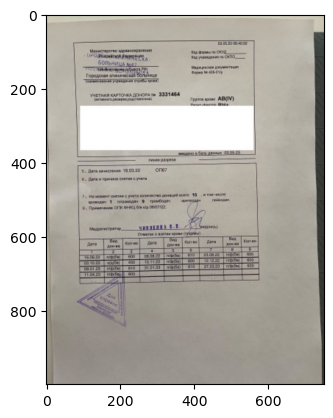

,ID,ID пользователя,Класс крови,Дата донации,Дата добавления донации,Тип донации,Регион,Место стадчи,Статус донации,Есть справка
0,209821,256578,Плазма,16.06.2022,03.05.2023,Безвозмездно,"Россия, Москва",718,Принята,Да
1,209822,256578,Плазма,08.08.2022,03.05.2023,Безвозмездно,"Россия, Москва",718,Принята,Да
2,209823,256578,Плазма,23.08.2022,03.05.2023,Безвозмездно,"Россия, Москва",718,Принята,Да
3,209824,256578,Цельная кровь,03.10.2022,03.05.2023,Безвозмездно,"Россия, Москва",718,Принята,Да
4,209826,256578,Плазма,10.11.2022,03.05.2023,Безвозмездно,"Россия, Москва",718,Принята,Да


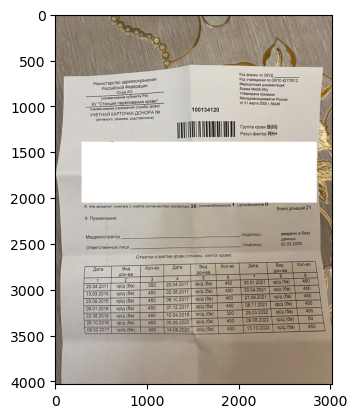

,ID,ID пользователя,Класс крови,Дата донации,Дата добавления донации,Тип донации,Регион,Место стадчи,Статус донации,Есть справка
0,216498,233749,Цельная кровь,20.04.2011,01.06.2023,Безвозмездно,"Россия, Ханты-Мансийский Автономный округ - Юг...",572,Принята,Да
1,216497,233749,Цельная кровь,13.03.2015,01.06.2023,Безвозмездно,"Россия, Ханты-Мансийский Автономный округ - Юг...",572,Принята,Да
2,216496,233749,Цельная кровь,25.09.2015,01.06.2023,Безвозмездно,"Россия, Ханты-Мансийский Автономный округ - Юг...",572,Принята,Да
3,216495,233749,Цельная кровь,06.01.2016,01.06.2023,Безвозмездно,"Россия, Ханты-Мансийский Автономный округ - Юг...",572,Принята,Да
4,216494,233749,Цельная кровь,22.08.2016,01.06.2023,Безвозмездно,"Россия, Ханты-Мансийский Автономный округ - Юг...",572,Принята,Да


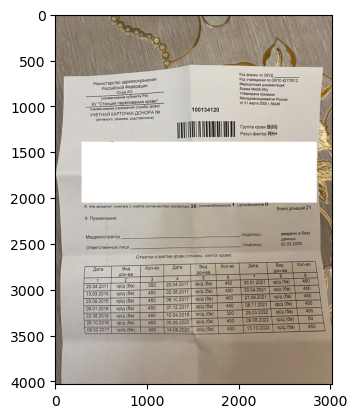

,ID,ID пользователя,Класс крови,Дата донации,Дата добавления донации,Тип донации,Регион,Место стадчи,Статус донации,Есть справка
0,216498,233749,Цельная кровь,20.04.2011,01.06.2023,Безвозмездно,"Россия, Ханты-Мансийский Автономный округ - Юг...",572,Принята,Да
1,216497,233749,Цельная кровь,13.03.2015,01.06.2023,Безвозмездно,"Россия, Ханты-Мансийский Автономный округ - Юг...",572,Принята,Да
2,216496,233749,Цельная кровь,25.09.2015,01.06.2023,Безвозмездно,"Россия, Ханты-Мансийский Автономный округ - Юг...",572,Принята,Да
3,216495,233749,Цельная кровь,06.01.2016,01.06.2023,Безвозмездно,"Россия, Ханты-Мансийский Автономный округ - Юг...",572,Принята,Да
4,216494,233749,Цельная кровь,22.08.2016,01.06.2023,Безвозмездно,"Россия, Ханты-Мансийский Автономный округ - Юг...",572,Принята,Да


In [10]:
# проверка случайно выбранного фото и эталонной таблицы

its = 3

for i in range(its):
    test = random.choice(pairs_list)
    df = pd.read_csv(rootdir+test+'.csv')
    img = cv2.imread(rootdir+test+'.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show();
    display(df.head())

Фото предоставленны в различном качестве и разрешении, на некоторых фото присутствуют jpg-артефакты, на некоторых фото часть синей печати медицинской организации попала на искомую таблицу.

В предоставленных csv-файлах присутствуют колонки, которые невозможно заполнить информацией с фото.

## Предобработка

Цели, которые должны быть достигнуты на шаге предобработки:
- Нормализация изображения, удаление артефактов
- Повышение читаемости текста
- Приведение изображения к форме, лучше воспринимаемой OCR